In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading a test case with some data

First we define a collision checker function.

In [2]:
def is_collision_free(x,y):
    columns = []
    columns.append(((-math.pi/2 - 0.2, -math.pi/2 + 0.2),(-0.1,0.1)))
    columns.append(((-0.2, 0.2),(-1.1,-0.9)))
    columns.append(((math.pi/2 - 0.2, math.pi/2 + 0.2),(0.9,1.1)))
    if x <= -math.pi or x > math.pi or y <= -math.pi or y > math.pi:
        raise Exception("point needs to be in [-pi,pi] x [-pi,pi]")
    for column in columns:
        in_x_col = x >= column[0][0] and x <= column[0][1]
        in_y_op = y > column[1][0] and y < column[1][1]
        if in_x_col and not in_y_op:
            return False
    return True

Now we have a look at the configuration space that this collision checker defines:

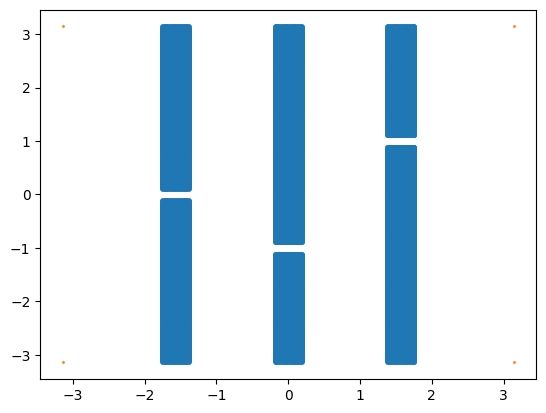

In [3]:
num_samples = 500

x_values = [ math.pi * (n/num_samples) - math.pi * (1-n/num_samples) for n in range(1,num_samples+1)]
y_values = x_values
value_grid = []
for y in y_values:
    y_section = [(x,y,is_collision_free(x,y)) for x in x_values]
    value_grid.append(y_section)

x_collisions = []
y_collisions = []
for y_row in value_grid:
    for entry in y_row:
        if not entry[2]:
            x_collisions.append(entry[0])
            y_collisions.append(entry[1])
plt.scatter(x_collisions, y_collisions, s =5)
plt.scatter([-3.1415,-3.1415, 3.1415,3.1415], [-3.1415,3.1415,-3.1415,3.1415], s = 1)

Now `value_grid` is a `500 x 500` list. It has one list for each of the 500 y-values. This list has 500 entries, one for each x-value and whether or not that point is in collision or not. Let's turn this into a `250000 x 3` tensor (250,000 data points, each with a x-value, a y-value, and a collision boolean).

In [4]:
train_data = torch.tensor([value_grid[i][j] for i in range(500) for j in range(500)])

In [5]:
train_data.shape

torch.Size([250000, 3])

In [6]:
train_data[0] # (x-coord, y-coord, collision-free (= 1))

tensor([-3.1290, -3.1290,  1.0000])

In [7]:
# Separate the training data into the points and classes
train_point = train_data[:,:2]
train_class = train_data[:,2]

# Model 3
In this model, we are adding BCE loss for the classes.

In [8]:
class VAE3(nn.Module):
    def __init__(self, input_dim, latent_dim): # maybe adjust to take hidden layer dimension in as input?
        super(VAE3, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2)  # Two times latent_dim for mean and log-variance
        )

        # Point decoder layers
        self.point_decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim - 1) # not predicting the class
        )
            
        # Class decoder layers
        self.class_decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1), # just decoding 1 thing here: collision or not
            nn.Sigmoid() # make the prediction a probability
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        enc_output = self.encoder(x)
        mu, logvar = enc_output[:, :latent_dim], enc_output[:, latent_dim:]

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoding
        point_dec_output, class_dec_output = self.point_decoder(z), self.class_decoder(z)
        return point_dec_output, class_dec_output, mu, logvar

In [9]:
# Define the loss function (now we incorporate BCE).
def loss_function3(recon_x, x, recon_x_class, x_class, mu, logvar, alpha = 1, beta = 1):
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # BCE class loss
    class_loss = nn.functional.binary_cross_entropy(recon_x_class, x_class)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + alpha*kl_loss + beta*class_loss

### 2-d latent space

In [10]:
# Initialize the VAE
input_dim = 3
latent_dim = 2
vae = VAE3(input_dim, latent_dim)

In [11]:
# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-2)

# Put model in training mode
vae.train()

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    # Forward pass
    recon_point, recon_class, mu, logvar = vae(train_data)

    # Compute the loss
    loss = loss_function3(recon_point, train_point, recon_class.view(250000), train_class, mu, logvar, 0.1, 1)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Now you can use the trained VAE for encoding and decoding

Epoch 0/1000, Loss: 1614266.875
Epoch 10/1000, Loss: 945226.625
Epoch 20/1000, Loss: 305718.65625
Epoch 30/1000, Loss: 228996.53125
Epoch 40/1000, Loss: 193568.1875
Epoch 50/1000, Loss: 165877.875
Epoch 60/1000, Loss: 151691.96875
Epoch 70/1000, Loss: 145054.8125
Epoch 80/1000, Loss: 140132.546875
Epoch 90/1000, Loss: 137468.9375
Epoch 100/1000, Loss: 135467.890625
Epoch 110/1000, Loss: 133970.734375
Epoch 120/1000, Loss: 132988.171875
Epoch 130/1000, Loss: 132145.96875
Epoch 140/1000, Loss: 131417.65625
Epoch 150/1000, Loss: 130888.515625
Epoch 160/1000, Loss: 130406.40625
Epoch 170/1000, Loss: 130126.578125
Epoch 180/1000, Loss: 129871.203125
Epoch 190/1000, Loss: 129583.84375
Epoch 200/1000, Loss: 129460.7109375
Epoch 210/1000, Loss: 129413.8671875
Epoch 220/1000, Loss: 129188.1796875
Epoch 230/1000, Loss: 129099.9765625
Epoch 240/1000, Loss: 128914.125
Epoch 250/1000, Loss: 128836.2578125
Epoch 260/1000, Loss: 128820.859375
Epoch 270/1000, Loss: 128683.0625
Epoch 280/1000, Loss: 12

Text(0, 0.5, 'loss')

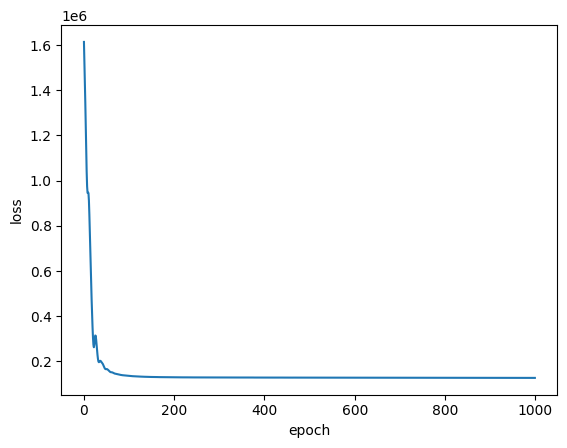

In [12]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

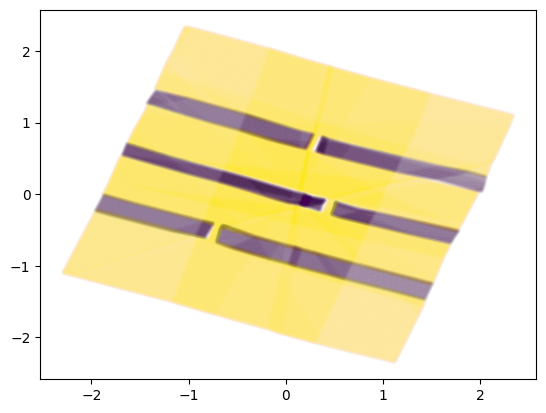

In [13]:
embeds = vae.encoder(train_data)[:, :latent_dim]
plt.scatter(embeds[:,0].detach(), embeds[:,1].detach(), c = train_data[:,2], alpha = 0.01, s = 5)

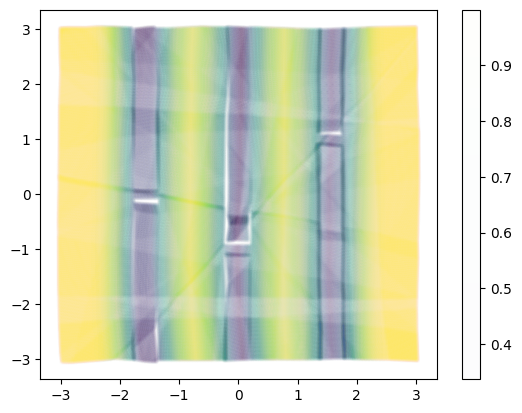

In [14]:
decodes = vae.point_decoder(embeds).detach()
plt.scatter(decodes[:,0], decodes[:,1], c = vae.class_decoder(embeds).detach(), alpha = 0.01, s = 5)
plt.colorbar()

### 1-d latent space

In [15]:
# Initialize the VAE
input_dim = 3
latent_dim = 1
vae = VAE3(input_dim, latent_dim)

In [16]:
# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-2)

# Put model in training mode
vae.train()

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    # Forward pass
    recon_point, recon_class, mu, logvar = vae(train_data)

    # Compute the loss
    loss = loss_function3(recon_point, train_point, recon_class.view(250000), train_class, mu, logvar, 0.1, 1)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Now you can use the trained VAE for encoding and decoding

Epoch 0/1000, Loss: 1763250.0
Epoch 10/1000, Loss: 1308186.125
Epoch 20/1000, Loss: 987309.0625
Epoch 30/1000, Loss: 932109.0625
Epoch 40/1000, Loss: 908087.0625
Epoch 50/1000, Loss: 897498.8125
Epoch 60/1000, Loss: 892296.3125
Epoch 70/1000, Loss: 885465.4375
Epoch 80/1000, Loss: 874048.9375
Epoch 90/1000, Loss: 853522.875
Epoch 100/1000, Loss: 822522.5
Epoch 110/1000, Loss: 786691.625
Epoch 120/1000, Loss: 754819.5625
Epoch 130/1000, Loss: 734217.25
Epoch 140/1000, Loss: 717609.0625
Epoch 150/1000, Loss: 696509.3125
Epoch 160/1000, Loss: 665018.0
Epoch 170/1000, Loss: 629054.6875
Epoch 180/1000, Loss: 590408.875
Epoch 190/1000, Loss: 553411.3125
Epoch 200/1000, Loss: 530401.9375
Epoch 210/1000, Loss: 505580.34375
Epoch 220/1000, Loss: 488620.34375
Epoch 230/1000, Loss: 469866.5625
Epoch 240/1000, Loss: 457835.65625
Epoch 250/1000, Loss: 446955.15625
Epoch 260/1000, Loss: 431902.15625
Epoch 270/1000, Loss: 426393.15625
Epoch 280/1000, Loss: 404779.4375
Epoch 290/1000, Loss: 396421.968

Text(0, 0.5, 'loss')

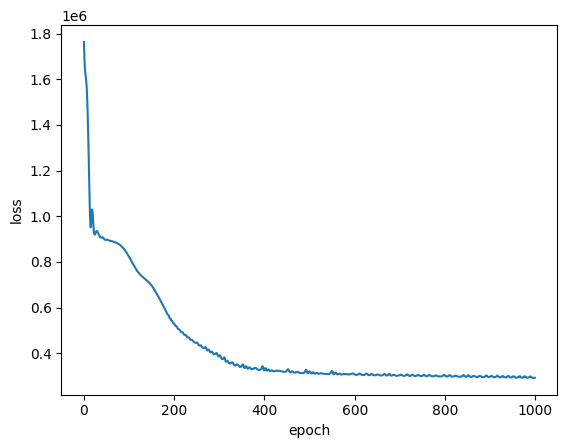

In [17]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

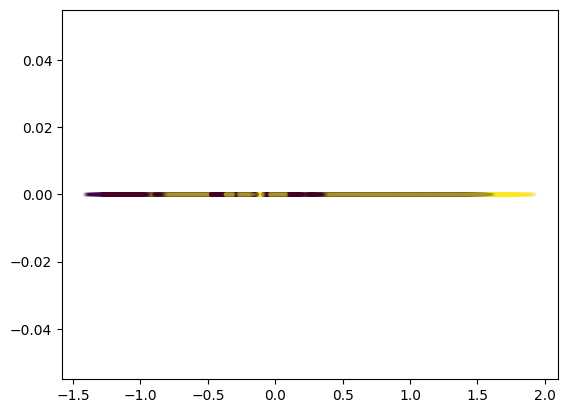

In [18]:
embeds = vae.encoder(train_data)[:, :latent_dim]
plt.scatter(embeds[:,0].detach(), torch.zeros_like(embeds[:,0].detach()), c = train_data[:,2], alpha = 0.01, s = 5)

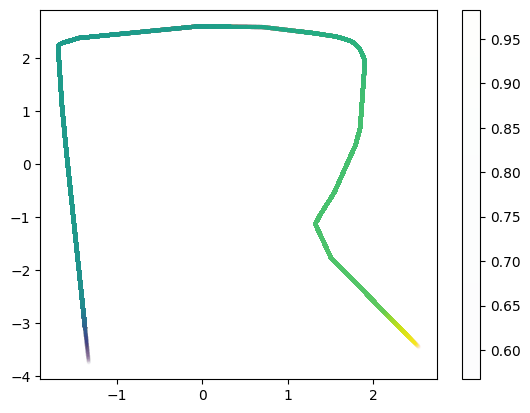

In [19]:
decodes = vae.point_decoder(embeds).detach()
plt.scatter(decodes[:,0], decodes[:,1], c = vae.class_decoder(embeds).detach(), alpha = 0.01, s = 5)
plt.colorbar()

# With minibatches

In [20]:
# Initialize the VAE
input_dim = 3
latent_dim = 2
vae = VAE3(input_dim, latent_dim)

In [21]:
# Where we'll keep track of the batch losses
losses = []

In [22]:
# Set up optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Put model in training mode
vae.train()

# Set batch size
batch_size = 1000

# Training loop
num_epochs = 50
for epoch in range(num_epochs): # try implementing the minibatch gradient descent?
    # Set up a data loader
    loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
    
    # Loop through the batches
    for batch in loader:
        # Forward pass
        recon_point, recon_class, mu, logvar = vae(batch)
        
        # Separate the points from the classes for the loss function
        train_point = batch[:,:2]
        train_class = batch[:,2]

        # Compute the loss
        loss = loss_function3(recon_point, train_point, recon_class.view(batch_size), train_class, mu, logvar, 0.1, 1)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        # Print the loss for every few epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Now you can use the trained VAE for encoding and decoding

Epoch 0/50, Loss: 760.9481811523438
Epoch 10/50, Loss: 515.2947998046875
Epoch 20/50, Loss: 505.29791259765625
Epoch 30/50, Loss: 494.6767272949219
Epoch 40/50, Loss: 495.8249816894531


Text(0, 0.5, 'loss')

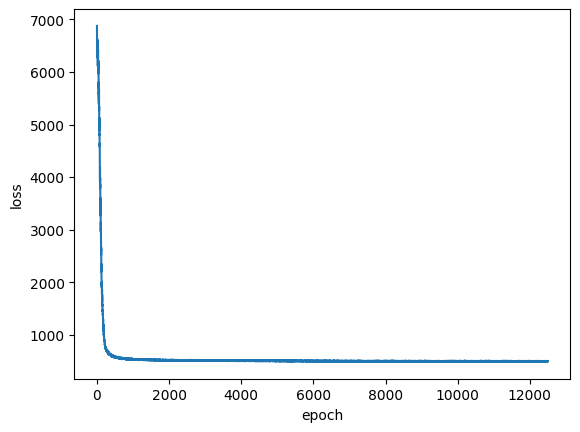

In [23]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

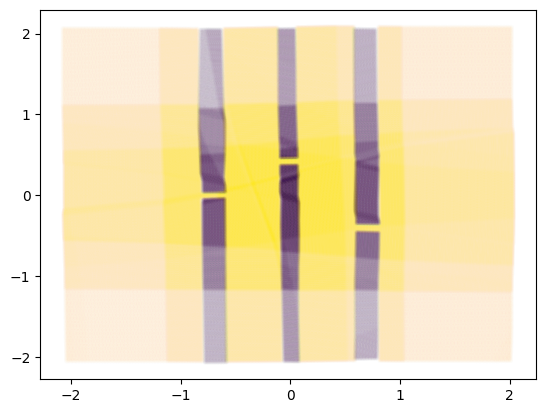

In [24]:
embeds = vae.encoder(train_data)[:, :latent_dim]
plt.scatter(embeds[:,0].detach(), embeds[:,1].detach(), c = train_data[:,2], alpha = 0.01, s = 5)

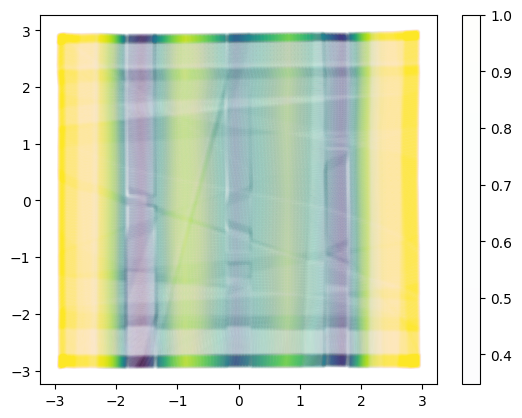

In [25]:
decodes = vae.point_decoder(embeds).detach()
plt.scatter(decodes[:,0], decodes[:,1], c = vae.class_decoder(embeds).detach(), alpha = 0.01, s = 5)
plt.colorbar()